In [1]:
#LSTM展示文件
#转换为其他数据需要修改i值、调整time_steps等参数

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import  sequence
from keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys

In [2]:
dataFilePaths = ['../input/timeseries/ec2_cpu_utilization_24ae8d.csv','../input/timeseries/exchange-4_cpc_results.csv',
                 '../input/timeseries/occupancy_t4013.csv','../input/timeseries/TravelTime_387.csv','../input/timeseries/Twitter_volume_AMZN.csv']

In [3]:
i = 2
dataFilePath = dataFilePaths[i]

In [4]:
df = pd.read_csv(filepath_or_buffer = dataFilePath, header = 0)
print('shape:', df.shape[0])
print('head:')
print(df.head(5))

shape: 2500
head:
             timestamp  value
0  2015-09-01 11:30:00  13.56
1  2015-09-01 11:35:00   8.33
2  2015-09-01 11:40:00  11.78
3  2015-09-01 11:55:00  15.28
4  2015-09-01 12:00:00  10.06


Text(0.5, 1.0, 'Time Series of value by date time')

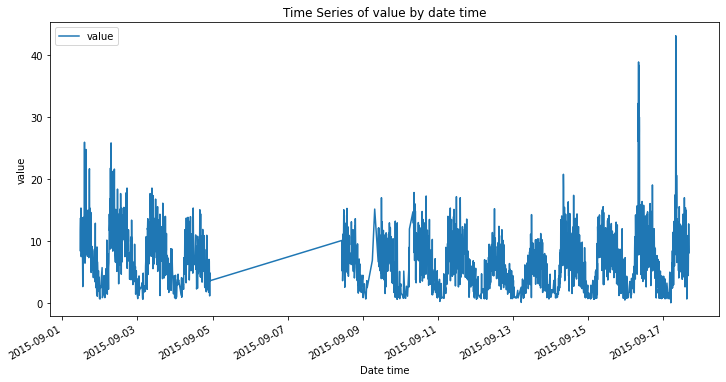

In [5]:
df['Datetime'] = pd.to_datetime(df['timestamp'])#利用时间戳生成df列
df.plot(x = 'Datetime', y = 'value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('value')
plt.title('Time Series of value by date time')

In [6]:
df.value.describe() 

count    2500.000000
mean        7.242640
std         4.372321
min         0.000000
25%         4.060000
50%         6.830000
75%         9.830000
max        43.060000
Name: value, dtype: float64

describe后可以看出max和min的差距较大，因此进行缩放

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns = ['value'])
df.head(5)

,timestamp,value,Datetime,scaled_value
0,2015-09-01 11:30:00,13.56,2015-09-01 11:30:00,0.314909
1,2015-09-01 11:35:00,8.33,2015-09-01 11:35:00,0.193451
2,2015-09-01 11:40:00,11.78,2015-09-01 11:40:00,0.273572
3,2015-09-01 11:55:00,15.28,2015-09-01 11:55:00,0.354854
4,2015-09-01 12:00:00,10.06,2015-09-01 12:00:00,0.233627


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

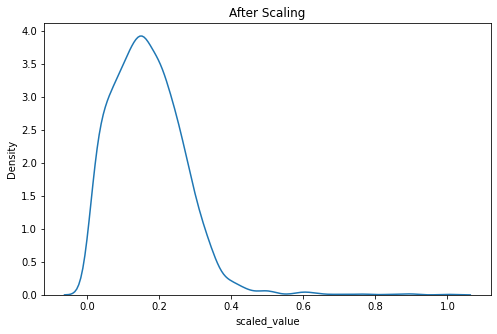

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax = ax1)

In [9]:
time_steps = 48 #时间数据间隔为30minz则48为24小时
#将时间序列拆分为长度为48的子序列的滚动代码
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 32)            4352      
_________________________________________________________________
dense (Dense)                (None, 48, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
#针对测试集进行预测
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



import math
from sklearn.metrics import mean_squared_error


# gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

sequence = np.array(df['scaled_value'])
print(sequence)
# time_steps = 48
time_steps = 48


samples = len(sequence)
trim = samples%time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples-trim]

sequence_trimmed.shape = (subsequences, time_steps, 1)

testing_dataset = sequence_trimmed

testing_pred = model.predict(x=testing_dataset)


testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]),testing_dataset.shape[2])

print(testing_pred.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]),testing_pred.shape[2])
print(testing_pred.shape)

[0.31490943 0.193451   0.27357176 ... 0.23223409 0.21806781 0.18718068]
(52, 48, 1)
(2496, 1)


In [11]:
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

In [12]:
tmp = pd.DataFrame({'dist':dist})
df['dist'] = tmp

In [13]:
scores = dist.copy()
scores.sort()
cutoff = int(0.999*len(scores))
threshold = scores[cutoff]
print(threshold)
print(scores)

0.498415204933838
[0.00141101 0.00341678 0.00541131 ... 0.4984152  0.49970254 0.50528124]


In [14]:
z = zip(dist >=threshold, dist)

y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)



In [15]:
# dist

In [16]:
class Visualization:
    labels = ['Normal', 'Anomaly']
    
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error':error,
                                'true':y}).groupby('true')
        figure, axes = plt.subplots(figsize = (12,8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name==1 else 'o', linestyle='',
                     color='r' if name==1 else 'g', label='Anomaly' if name==1 else 'Normal')
            
        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors = 'b', zorder=100, label = '')
        axes.legend()
        plt.show()
    
    def draw_error(self, error, threshold):
       
        plt.figure(figsize = (10,8))

        plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

        plt.hlines(threshold, xlim = 0, xmax=len(error)-1, colors = 'r', zorder=100, label = 'Threshold')
        plt.legend()
        plt.show()




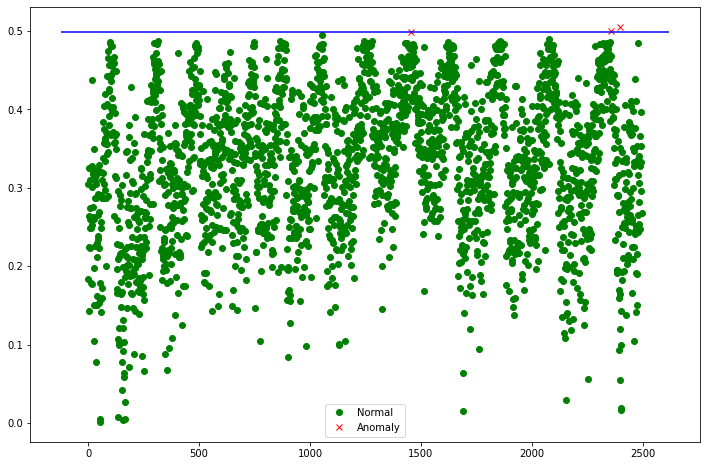

In [17]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

❌为异常点

In [20]:
df.to_csv('./LSTM03.csv')